<a href="https://colab.research.google.com/github/krmonline/AnomalyDetection/blob/master/LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/krmonline/AnomalyDetection/master/data/timeseries1.csv",names=['val'])
series = df.val.values

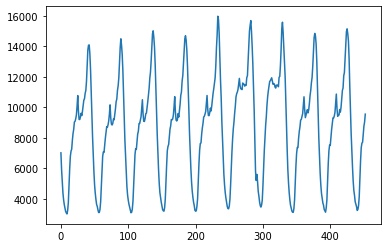

In [3]:
plt.plot(series)

In [4]:
from sklearn.preprocessing import minmax_scale

In [5]:
series_scale = minmax_scale(series)

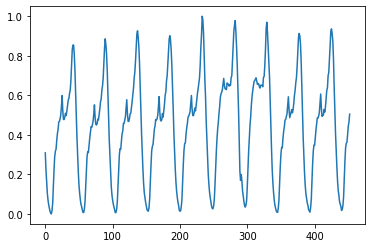

In [6]:
plt.plot(series_scale)

In [7]:
time = range(len(series))
split_time = 300
time_train = time[:split_time]
x_train = series_scale[:split_time]
time_valid = time[split_time:]
x_valid = series_scale[split_time:]

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [10]:
window_size = 10
batch_size = 10
shuffle_buffer_size = 1000
data = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)
data_test = windowed_dataset(x_valid,window_size,batch_size,shuffle_buffer_size)
#for i,j in data:
#  print(i.numpy())
#  print(j.numpy())

In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  #tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
model.compile(loss='mse',optimizer='adam')
loss = []
val_loss = []

Epoch 1/200
29/29 [==============================] - 0s 17ms/step - loss: 9.5691 - val_loss: 1.3126
Epoch 2/200
29/29 [==============================] - 0s 5ms/step - loss: 1.0433 - val_loss: 0.5924
Epoch 3/200
29/29 [==============================] - 0s 5ms/step - loss: 0.3556 - val_loss: 0.2192
Epoch 4/200
29/29 [==============================] - 0s 5ms/step - loss: 0.1605 - val_loss: 0.1009
Epoch 5/200
29/29 [==============================] - 0s 5ms/step - loss: 0.0718 - val_loss: 0.0526
Epoch 6/200
29/29 [==============================] - 0s 5ms/step - loss: 0.0429 - val_loss: 0.0287
Epoch 7/200
29/29 [==============================] - 0s 5ms/step - loss: 0.0276 - val_loss: 0.0234
Epoch 8/200
29/29 [==============================] - 0s 5ms/step - loss: 0.0216 - val_loss: 0.0182
Epoch 9/200
29/29 [==============================] - 0s 5ms/step - loss: 0.0187 - val_loss: 0.0198
Epoch 10/200
29/29 [==============================] - 0s 5ms/step - loss: 0.0148 - val_loss: 0.0132
Epoch 11

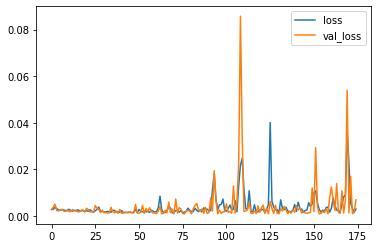

In [12]:
history = model.fit(data, epochs=200,verbose=1,validation_data=data_test)
loss = loss + history.history['loss']
val_loss = val_loss + history.history['val_loss']
plt.plot(loss[25:])
plt.plot(val_loss[25:])
plt.legend(['loss','val_loss'])

In [13]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [14]:
df_test = pd.read_csv("https://raw.githubusercontent.com/krmonline/AnomalyDetection/master/data/timeseries2.csv",names=['val'])
df_test = df_test.val.values

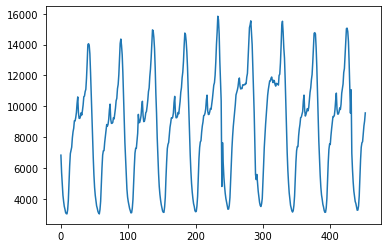

In [15]:
plt.plot(df_test)

In [16]:
series_test = minmax_scale(df_test)
#series_test = series_scale

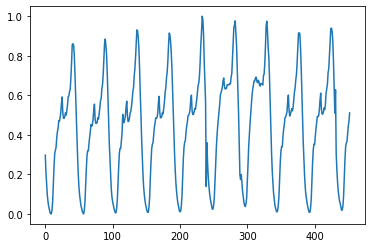

In [17]:
plt.plot(series_test)

In [18]:
forecast = []
results = []
for time in range(len(series_test) - window_size):
  forecast.append(model.predict(series_test[time:time + window_size][np.newaxis]))

#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [19]:
len(forecast),len(results)

(443, 443)

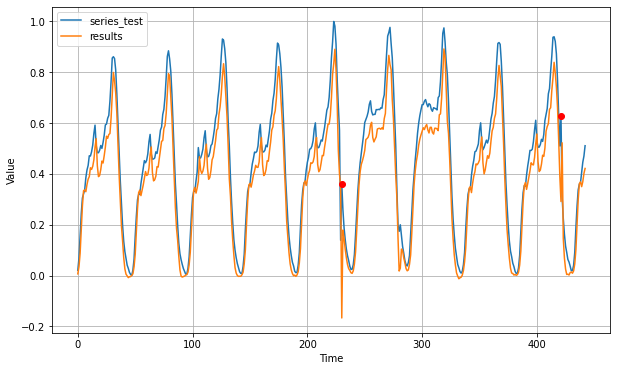

In [34]:
plt.figure(figsize=(10, 6))

plot_series(range(len(series_test) - window_size), series_test[window_size:])
plot_series(range(len(series_test) - window_size), results)
plt.legend(['series_test','results'])
for i in range(len(series_test[window_size:])):
  if np.abs(series_test[window_size:][i] - results[i]) > 0.3:
    plt.plot(i,series_test[window_size:][i],'ro')

Text(0, 0.5, 'Difference')

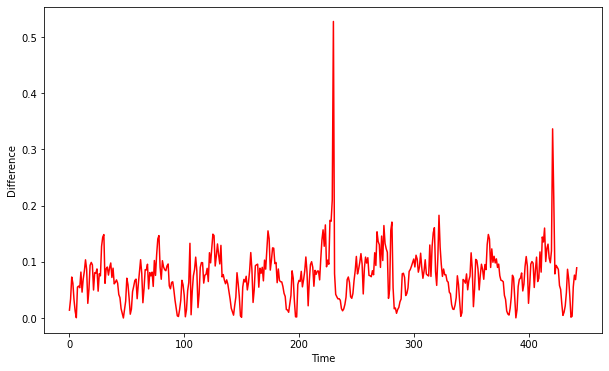

In [33]:
plt.figure(figsize=(10, 6))
diff  = []
for i in range(len(series_test[window_size:])):
    diff.append(np.abs(series_test[window_size:][i] - results[i]))
plt.plot(diff,'r-')
plt.xlabel("Time")
plt.ylabel("Difference")

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(x_valid,results)

0.001204930987730857

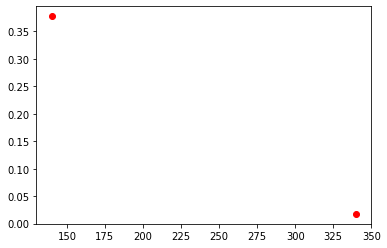

In [ ]:
for i in range(len(x_valid)):
  if np.abs(x_valid[i] - results[i]) > 0.2:
    plt.plot(i,x_valid[i],'ro')